In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from ydata_profiling import ProfileReport
#from autoviz import AutoViz_Class 

## Loading Dataset

In [82]:
dataframe = pd.read_csv('database.csv', na_values=[''])
work_qstn =  pd.read_csv('meta-data.csv',na_values= [''])

## Ordering Columns & Variable Types

In [83]:
dataframe.columns.tolist()

['Unnamed: 0',
 'row_close',
 'levelCounter',
 'trial_set',
 'time_close',
 'row_start',
 'time_start',
 'time',
 'time_ms',
 'ptcp',
 'feedbackType',
 'correctCounter',
 'Change Flag']

In [84]:
new_order = ['ptcp',
             'trial_set',
             'levelCounter',
             #'row_start',
             #'row_close',
             'time_ms',
             'feedbackType',
             'correctCounter'
             ]

Lets take a look at the variable types and null values:

In [85]:
work_df = dataframe[new_order]
work_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362 entries, 0 to 2361
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ptcp            2362 non-null   object 
 1   trial_set       2362 non-null   int64  
 2   levelCounter    2358 non-null   float64
 3   time_ms         2325 non-null   float64
 4   feedbackType    2358 non-null   object 
 5   correctCounter  2193 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 110.8+ KB


In [86]:
work_qstn.columns.tolist()

['PARTICIPANT ID',
 'DATE OF T ESTING',
 'TIME',
 'HANDEDNESS',
 'SEX',
 'AGE',
 'COMMENTS',
 'pre',
 'post',
 'body°',
 'file numbers',
 'pre_csq1',
 'pre_csq2',
 'pre_csq3',
 'pre_csq4',
 'pre_csq5',
 'pre_csq6',
 'pre_csq7',
 'pre_csq8',
 'pre_csq9',
 'pre_csq10',
 'pre_csq11',
 'pre_csq12',
 'pre_csq13',
 'pre_csq14',
 'pre_csq15',
 'pre_csq16',
 'post_csq1',
 'post_csq2',
 'post_csq3',
 'post_csq4',
 'post_csq5',
 'post_csq6',
 'post_csq7',
 'post_csq8',
 'post_csq9',
 'post_csq10',
 'post_csq11',
 'post_csq12',
 'post_csq13',
 'post_csq14',
 'post_csq15',
 'post_csq16',
 'EHQ1',
 'EHQ2',
 'EHQ3',
 'EHQ4',
 'EHQ5',
 'EHQ6',
 'EHQ7',
 'EHQ8',
 'EHQ9',
 'EHQ10',
 'EHQI',
 'EHQII',
 'EHQ_F',
 'post_VRF1',
 'post_VRF2',
 'post_VRF3',
 'post_VRF4',
 'post_VRF5',
 'post_VRF6',
 'post_VRF7',
 'post_VRF8',
 'post_VRF9',
 'post_VRF10',
 'post_VRF11',
 'post_VRF12',
 'post_VRF13',
 'post_VRF14',
 'post_VRF15',
 'post_VRF16',
 'post_VRF17',
 'post_VRF18',
 'post_VRF19',
 'post_VRF20',
 'post

Selecting new order and columns to keep

In [87]:
new_order = ['PARTICIPANT ID',
 #'DATE OF T ESTING',
 #'TIME',
 'HANDEDNESS',
 'SEX',
 'AGE',
 #'COMMENTS',
 'pre',
 'post',
 'body°',
 #'file numbers',
 'pre_csq1',
 'pre_csq2',
 'pre_csq3',
 'pre_csq4',
 'pre_csq5',
 'pre_csq6',
 'pre_csq7',
 'pre_csq8',
 'pre_csq9',
 'pre_csq10',
 'pre_csq11',
 'pre_csq12',
 'pre_csq13',
 'pre_csq14',
 'pre_csq15',
 'pre_csq16',
 'post_csq1',
 'post_csq2',
 'post_csq3',
 'post_csq4',
 'post_csq5',
 'post_csq6',
 'post_csq7',
 'post_csq8',
 'post_csq9',
 'post_csq10',
 'post_csq11',
 'post_csq12',
 'post_csq13',
 'post_csq14',
 'post_csq15',
 'post_csq16',
 'EHQ1',
 'EHQ2',
 'EHQ3',
 'EHQ4',
 'EHQ5',
 'EHQ6',
 'EHQ7',
 'EHQ8',
 'EHQ9',
 'EHQ10',
 'EHQI',
 'EHQII',
 'EHQ_F',
 'post_VRF1',
 'post_VRF2',
 'post_VRF3',
 'post_VRF4',
 'post_VRF5',
 'post_VRF6',
 'post_VRF7',
 'post_VRF8',
 'post_VRF9',
 'post_VRF10',
 'post_VRF11',
 'post_VRF12',
 'post_VRF13',
 'post_VRF14',
 'post_VRF15',
 'post_VRF16',
 'post_VRF17',
 'post_VRF18',
 'post_VRF19',
 'post_VRF20',
 'post_VRF21',
 'post_VRF22',
 'post_VRF23',
 'post_VRF24',
 'post_VRF25',
 'post_VRF26',
 'post_VRF27']

Streamlining the Analysis by Removing Unnecessary Columns.

In [88]:
work_qstn = work_qstn[new_order]

Data Transformations to Enable the Merging of Two Tables.

In [89]:
work_qstn['ptcp'] = work_qstn['PARTICIPANT ID'].str.lower().str.replace('_', '', regex=True)
work_qstn['ptcp'] = work_qstn['ptcp'].str.replace('_', '', regex=True)
work_qstn['ptcp'] = work_qstn['ptcp'].str.replace('-backup', '', regex=True)
work_qstn['body°'] = work_qstn['body°'].str.replace('°', '', regex=True).astype('float64')
# List of columns that need to be converted
columns_to_convert = [
    'post_VRF1', 'post_VRF2', 'post_VRF3', 'post_VRF4', 'post_VRF5', 'post_VRF6',
    'post_VRF7', 'post_VRF8', 'post_VRF9', 'post_VRF10', 'post_VRF11', 'post_VRF12',
    'post_VRF13', 'post_VRF14', 'post_VRF15', 'post_VRF16', 'post_VRF17', 'post_VRF18',
    'post_VRF19', 'post_VRF20', 'post_VRF21', 'post_VRF22', 'post_VRF23', 'post_VRF24',
    'post_VRF25', 'post_VRF26']

for column in columns_to_convert:
    # Replace space characters with NaN
    work_qstn[column] = work_qstn[column].replace(' ', np.nan)


work_qstn.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 80 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PARTICIPANT ID  23 non-null     object 
 1   HANDEDNESS      23 non-null     object 
 2   SEX             23 non-null     object 
 3   AGE             23 non-null     int64  
 4   pre             23 non-null     int64  
 5   post            21 non-null     object 
 6   body°           23 non-null     float64
 7   pre_csq1        22 non-null     float64
 8   pre_csq2        23 non-null     int64  
 9   pre_csq3        22 non-null     float64
 10  pre_csq4        23 non-null     int64  
 11  pre_csq5        23 non-null     int64  
 12  pre_csq6        23 non-null     int64  
 13  pre_csq7        23 non-null     int64  
 14  pre_csq8        23 non-null     int64  
 15  pre_csq9        23 non-null     int64  
 16  pre_csq10       23 non-null     int64  
 17  pre_csq11       23 non-null     int64

Merging the 2 together:

In [90]:
merged_df = pd.merge(work_df, work_qstn, on='ptcp', how='left')

I will tranfor 'ptcp' and 'trial set' in categorical values because the represent the participants, the stage at which the experiment developed and the feedback category. Not really numerical values.

In [91]:
#------ Behavioral data treatment
merged_df.loc[:, 'ptcp'] = merged_df['ptcp'].astype('category')
merged_df.loc[:, 'trial_set'] = merged_df['trial_set'].astype('category')
merged_df.loc[:, 'feedbackType'] = merged_df['feedbackType'].astype('category')
#------ Metadata treatment
merged_df.loc[:, 'HANDEDNESS'] = merged_df['HANDEDNESS'].astype('category')
merged_df.loc[:, 'SEX'] = merged_df['SEX'].astype('category')
merged_df.loc[:, 'AGE'] = merged_df['AGE'].astype('int')
merged_df.loc[:, 'pre'] = merged_df['pre'].astype('int')
merged_df.loc[:, 'post'] = merged_df['post'].astype('Int64')
#------ Pre Cyber Sickness Questionaire 
merged_df.loc[:, 'pre_csq1'] = merged_df['pre_csq1'].astype('Int64')
merged_df.loc[:, 'pre_csq2'] = merged_df['pre_csq2'].astype('Int64')
merged_df.loc[:, 'pre_csq3'] = merged_df['pre_csq3'].astype('Int64')
merged_df.loc[:, 'pre_csq4'] = merged_df['pre_csq4'].astype('Int64')
merged_df.loc[:, 'pre_csq5'] = merged_df['pre_csq5'].astype('Int64')
merged_df.loc[:, 'pre_csq6'] = merged_df['pre_csq6'].astype('Int64')
merged_df.loc[:, 'pre_csq7'] = merged_df['pre_csq7'].astype('Int64')
merged_df.loc[:, 'pre_csq8'] = merged_df['pre_csq8'].astype('Int64')
merged_df.loc[:, 'pre_csq9'] = merged_df['pre_csq9'].astype('Int64')
merged_df.loc[:, 'pre_csq10'] = merged_df['pre_csq10'].astype('Int64')
merged_df.loc[:, 'pre_csq11'] = merged_df['pre_csq11'].astype('Int64')
merged_df.loc[:, 'pre_csq12'] = merged_df['pre_csq12'].astype('Int64')
merged_df.loc[:, 'pre_csq13'] = merged_df['pre_csq13'].astype('Int64')
merged_df.loc[:, 'pre_csq14'] = merged_df['pre_csq14'].astype('Int64')
merged_df.loc[:, 'pre_csq15'] = merged_df['pre_csq15'].astype('Int64')
merged_df.loc[:, 'pre_csq16'] = merged_df['pre_csq16'].astype('Int64')
#------ Post Cyber Sickness Questionaire 
merged_df.loc[:, 'post_csq1'] = merged_df['post_csq1'].astype('Int64')
merged_df.loc[:, 'post_csq2'] = merged_df['post_csq2'].astype('Int64')
merged_df.loc[:, 'post_csq3'] = merged_df['post_csq3'].astype('Int64')
merged_df.loc[:, 'post_csq4'] = merged_df['post_csq4'].astype('Int64')
merged_df.loc[:, 'post_csq5'] = merged_df['post_csq5'].astype('Int64')
merged_df.loc[:, 'post_csq6'] = merged_df['post_csq6'].astype('Int64')
merged_df.loc[:, 'post_csq7'] = merged_df['post_csq7'].astype('Int64')
merged_df.loc[:, 'post_csq8'] = merged_df['post_csq8'].astype('Int64')
merged_df.loc[:, 'post_csq9'] = merged_df['post_csq9'].astype('Int64')
merged_df.loc[:, 'post_csq10'] = merged_df['post_csq10'].astype('Int64')
merged_df.loc[:, 'post_csq11'] = merged_df['post_csq11'].astype('Int64')
merged_df.loc[:, 'post_csq12'] = merged_df['post_csq12'].astype('Int64')
merged_df.loc[:, 'post_csq13'] = merged_df['post_csq13'].astype('Int64')
merged_df.loc[:, 'post_csq14'] = merged_df['post_csq14'].astype('Int64')
merged_df.loc[:, 'post_csq15'] = merged_df['post_csq15'].astype('Int64')
merged_df.loc[:, 'post_csq16'] = merged_df['post_csq16'].astype('Int64')
#------ Handedness Questionaire.
merged_df.loc[:, 'EHQ1'] =  merged_df['EHQ1'].astype('Int64')
merged_df.loc[:, 'EHQ2'] =  merged_df['EHQ2'].astype('Int64')
merged_df.loc[:, 'EHQ3'] =  merged_df['EHQ3'].astype('Int64')
merged_df.loc[:, 'EHQ4'] =  merged_df['EHQ4'].astype('Int64')
merged_df.loc[:, 'EHQ5'] =  merged_df['EHQ5'].astype('Int64')
merged_df.loc[:, 'EHQ6'] =  merged_df['EHQ6'].astype('Int64')
merged_df.loc[:, 'EHQ7'] =  merged_df['EHQ7'].astype('Int64')
merged_df.loc[:, 'EHQ8'] =  merged_df['EHQ8'].astype('Int64')
merged_df.loc[:, 'EHQ9'] =  merged_df['EHQ9'].astype('Int64')
merged_df.loc[:, 'EHQ10'] =  merged_df['EHQ10'].astype('Int64')
merged_df.loc[:, 'EHQI'] =  merged_df['EHQI'].astype('Int64')
merged_df.loc[:, 'EHQII'] =  merged_df['EHQII'].astype('Int64')
merged_df.loc[:, 'EHQ1_F'] =  merged_df['EHQ_F'].astype('category')
#------ 
merged_df.loc[:, 'post_VRF1'] =  merged_df['post_VRF1'].astype('Int64')
merged_df.loc[:, 'post_VRF3'] =  merged_df['post_VRF3'].astype('Int64')
merged_df.loc[:, 'post_VRF4'] =  merged_df['post_VRF4'].astype('Int64')
merged_df.loc[:, 'post_VRF5'] =  merged_df['post_VRF5'].astype('Int64')
merged_df.loc[:, 'post_VRF6'] =  merged_df['post_VRF6'].astype('Int64')
merged_df.loc[:, 'post_VRF7'] =  merged_df['post_VRF7'].astype('Int64')
merged_df.loc[:, 'post_VRF8'] =  merged_df['post_VRF8'].astype('Int64')
merged_df.loc[:, 'post_VRF9'] =  merged_df['post_VRF9'].astype('Int64')
merged_df.loc[:, 'post_VRF10'] =  merged_df['post_VRF10'].astype('Int64')
merged_df.loc[:, 'post_VRF11'] =  merged_df['post_VRF11'].astype('Int64')
merged_df.loc[:, 'post_VRF12'] =  merged_df['post_VRF12'].astype('Int64')
merged_df.loc[:, 'post_VRF13'] =  merged_df['post_VRF13'].astype('Int64')
merged_df.loc[:, 'post_VRF14'] =  merged_df['post_VRF14'].astype('Int64')
merged_df.loc[:, 'post_VRF15'] =  merged_df['post_VRF15'].astype('Int64')
merged_df.loc[:, 'post_VRF16'] =  merged_df['post_VRF16'].astype('Int64')
merged_df.loc[:, 'post_VRF17'] =  merged_df['post_VRF17'].astype('Int64')
merged_df.loc[:, 'post_VRF18'] =  merged_df['post_VRF18'].astype('Int64')
merged_df.loc[:, 'post_VRF19'] =  merged_df['post_VRF19'].astype('Int64')
merged_df.loc[:, 'post_VRF20'] =  merged_df['post_VRF20'].astype('Int64')
merged_df.loc[:, 'post_VRF21'] =  merged_df['post_VRF21'].astype('Int64')
merged_df.loc[:, 'post_VRF22'] =  merged_df['post_VRF22'].astype('Int64')
merged_df.loc[:, 'post_VRF23'] =  merged_df['post_VRF23'].astype('Int64')
merged_df.loc[:, 'post_VRF24'] =  merged_df['post_VRF24'].astype('Int64')
merged_df.loc[:, 'post_VRF25'] =  merged_df['post_VRF25'].astype('Int64')
merged_df.loc[:, 'post_VRF26'] =  merged_df['post_VRF26'].astype('Int64')





## Data Validation & Data Cleaning

man step of validation (such as varaible type, formating, uniqueness, are already performed in the construction of the data set). Nonetheless this second layer is for the final result. First we need to watch if after the tranformations of the raw-data all conditions look as expected

1.- We expect 22 participants and 36 trials per set. 

In [92]:
# Group the DataFrame by 'ptcp' and 'trial_set', then count unique values in 'levelCounter'
levels_per_set_per_participant = merged_df.groupby(['ptcp', 'trial_set'], observed=True)['levelCounter'].count()

# Display the result
print("\nNumber of levels per set per participant:")
print(levels_per_set_per_participant)


Number of levels per set per participant:
ptcp    trial_set
tsvr06  1            36
        2            36
        3            36
tsvr07  1            36
        2            36
                     ..
tsvr26  2            36
        3            35
tsvr27  1            36
        2            36
        3            35
Name: levelCounter, Length: 66, dtype: int64


Due to a failure in the excecution of the program while taking the experiment; the last level (35) is missing for most participants in set 3. I think we need to remove it for all participants in all sets since we don' want to umbalanced the results. 

In [93]:
# removing 
work_df2 =  merged_df[merged_df['levelCounter']<35]
work_df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2310 entries, 0 to 2360
Data columns (total 86 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ptcp            2310 non-null   object  
 1   trial_set       2310 non-null   category
 2   levelCounter    2310 non-null   float64 
 3   time_ms         2310 non-null   float64 
 4   feedbackType    2310 non-null   object  
 5   correctCounter  2145 non-null   float64 
 6   PARTICIPANT ID  2310 non-null   object  
 7   HANDEDNESS      2310 non-null   object  
 8   SEX             2310 non-null   object  
 9   AGE             2310 non-null   int64   
 10  pre             2310 non-null   int64   
 11  post            2100 non-null   object  
 12  body°           2310 non-null   float64 
 13  pre_csq1        2205 non-null   Int64   
 14  pre_csq2        2310 non-null   int64   
 15  pre_csq3        2205 non-null   Int64   
 16  pre_csq4        2310 non-null   int64   
 17  pre_csq5        231

After the removal we have the number of not exactly as designed. We need to check that even if the numbre of trials per condition is not exactly the same the 

In [94]:
# Group the DataFrame by 'ptcp' and 'trial_set', then count unique values in 'levelCounter'
check_per_level = work_df2.groupby(['levelCounter','feedbackType']).count()
check_per_level = check_per_level.reset_index()
check_per_level['deviation']= 22-check_per_level['ptcp']
print(check_per_level)



     levelCounter feedbackType  ptcp  trial_set  time_ms  correctCounter  \
0             0.0    congruent    21         21       21              21   
1             0.0  incongruent    22         22       22              16   
2             0.0         none    23         23       23              22   
3             1.0    congruent    23         23       23              20   
4             1.0  incongruent    23         23       23              22   
..            ...          ...   ...        ...      ...             ...   
100          33.0  incongruent    21         21       21              18   
101          33.0         none    25         25       25              23   
102          34.0    congruent    26         26       26              22   
103          34.0  incongruent    19         19       19              16   
104          34.0         none    21         21       21              21   

     PARTICIPANT ID  HANDEDNESS  SEX  AGE  ...  post_VRF20  post_VRF21  \
0            

The feedback Types are not exactly splited into three equal groups, there is a deviation wich I will look into at a participant level.  Next, we will t-test if this deviation is isgnificanttly different from 0. 
For every level we expect to see 22 participants in each condition, this is our ideal scenario. So for example, for level 1 we expect to have 22 partipants in case "congruent", 22 in case "incongruent" and 22 in case "none". Since this is not the case I will see how much the diviate form the ideal case (22 - x) and if this is statiscally different from 0. 

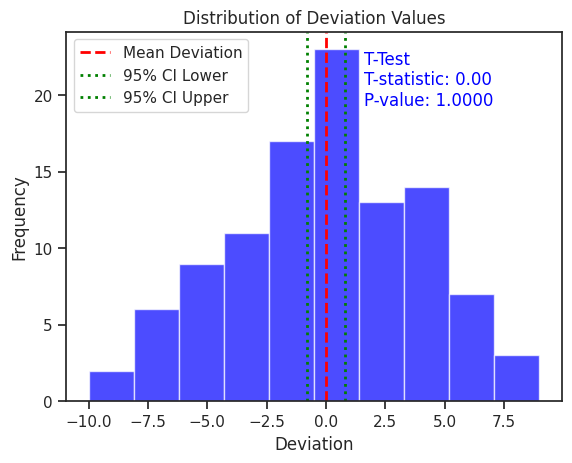

In [95]:

# Assuming your DataFrame is named check_per_level
deviation_values = check_per_level['deviation']

# Create the histogram
plt.hist(deviation_values, bins=10, color='blue', alpha=0.7)
plt.xlabel('Deviation')
plt.ylabel('Frequency')
plt.title('Distribution of Deviation Values')

# Calculate the mean and standard error of the mean (SEM)
mean_deviation = np.mean(deviation_values)
sem_deviation = np.std(deviation_values) / np.sqrt(len(deviation_values))

# Calculate the 95% confidence interval
ci_lower = mean_deviation - 1.96 * sem_deviation
ci_upper = mean_deviation + 1.96 * sem_deviation

# Perform a t-test (assuming a population mean of 0)
t_stat, p_value = stats.ttest_1samp(deviation_values, 0)

# Add the confidence interval and t-test result to the plot
plt.axvline(mean_deviation, color='red', linestyle='dashed', linewidth=2, label='Mean Deviation')
plt.axvline(ci_lower, color='green', linestyle='dotted', linewidth=2, label='95% CI Lower')
plt.axvline(ci_upper, color='green', linestyle='dotted', linewidth=2, label='95% CI Upper')

# Add t-test result to the plot
plt.annotate(f'T-Test\nT-statistic: {t_stat:.2f}\nP-value: {p_value:.4f}', xy=(0.6, 0.8), xycoords='axes fraction', fontsize=12, color='blue')

plt.legend(loc='upper left')
plt.show()


This shows that the median deviation of ptcp per category is 0. Which supports the argument that after removing level 35 of all the sample feedbacktype remains a legitimate independent variable. 

Now at a participantt point of view. We expect for each participantto have 36 levels pero condition. This is not now exactly the case so we creat a deviation varaible (36- x). The results look osmething like the following:

In [96]:
# Group the DataFrame by 'ptcp' and 'trial_set', then count unique values in 'levelCounter'
check_per_ptcp = work_df2.groupby(['ptcp','feedbackType']).count()
check_per_ptcp = check_per_ptcp.reset_index()
check_per_ptcp['deviation']= 35-check_per_ptcp['trial_set']
print(check_per_ptcp)

      ptcp feedbackType  trial_set  levelCounter  time_ms  correctCounter  \
0   tsvr06    congruent         35            35       35              33   
1   tsvr06  incongruent         34            34       34              31   
2   tsvr06         none         36            36       36              35   
3   tsvr07    congruent         35            35       35              32   
4   tsvr07  incongruent         33            33       33              30   
..     ...          ...        ...           ...      ...             ...   
61  tsvr26  incongruent         35            35       35              32   
62  tsvr26         none         35            35       35              33   
63  tsvr27    congruent         35            35       35              35   
64  tsvr27  incongruent         34            34       34              33   
65  tsvr27         none         36            36       36              36   

    PARTICIPANT ID  HANDEDNESS  SEX  AGE  ...  post_VRF20  post_VRF21  \
0 

I proceed to run a t.test to see if deviation is something different from 0. Its not .

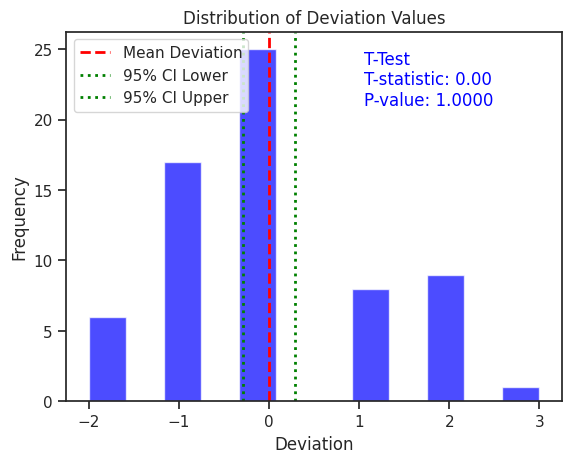

In [97]:
# Assuming your DataFrame is named check_per_level
deviation_values = check_per_ptcp['deviation']

# Create the histogram
plt.hist(deviation_values, bins=12, color='blue', alpha=0.7)
plt.xlabel('Deviation')
plt.ylabel('Frequency')
plt.title('Distribution of Deviation Values')

# Calculate the mean and standard error of the mean (SEM)
mean_deviation = np.mean(deviation_values)
sem_deviation = np.std(deviation_values) / np.sqrt(len(deviation_values))

# Calculate the 95% confidence interval
ci_lower = mean_deviation - 1.96 * sem_deviation
ci_upper = mean_deviation + 1.96 * sem_deviation

# Perform a t-test (assuming a population mean of 0)
t_stat, p_value = stats.ttest_1samp(deviation_values, 0)

# Add the confidence interval and t-test result to the plot
plt.axvline(mean_deviation, color='red', linestyle='dashed', linewidth=2, label='Mean Deviation')
plt.axvline(ci_lower, color='green', linestyle='dotted', linewidth=2, label='95% CI Lower')
plt.axvline(ci_upper, color='green', linestyle='dotted', linewidth=2, label='95% CI Upper')

# Add t-test result to the plot
plt.annotate(f'T-Test\nT-statistic: {t_stat:.2f}\nP-value: {p_value:.4f}', xy=(0.6, 0.8), xycoords='axes fraction', fontsize=12, color='blue')

plt.legend(loc='upper left')
plt.show()

Checking Correlation of the numeric variables.  


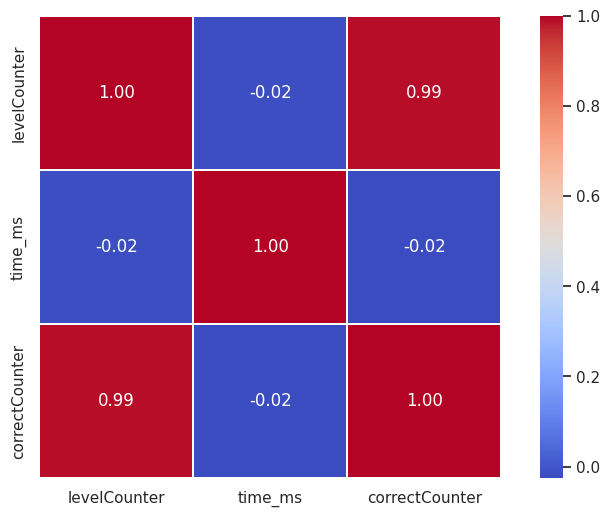

In [98]:
# Checking correlation between variables. 

numeric_df = work_df2[['levelCounter','time_ms', 'correctCounter']]

fig = plt.figure(figsize=(10, 6))
sns.set(font_scale=1)
sns.heatmap(numeric_df.corr(), cbar=True, annot=True, square=True,\
                 fmt='.2f',
                 annot_kws={'size': 12}, yticklabels=numeric_df.columns,\
                 xticklabels=numeric_df.columns, cmap = 'coolwarm',lw = .1)
plt.show()

In [99]:
profile = ProfileReport(work_df2, title='Yoyoma')
#profile.to_widgets()

As the EDA shows, reponse time is a highly skew variable with outlier. Wich we will remove and later tranform using natural log. Also I need to decide where in seconds I am going to make a cutoff. 

## Feature Engineering 
Now lets make a flag that is 1 when the trail is a mistake and with 0 when the answer was correct. For this we use the already existing variable 'correct value count'. 

In [100]:
work_df2['mistake_flag'] = work_df2['correctCounter'].apply(lambda x: 1 if pd.isna(x) else 0)
work_df2['mistake_flag'] = work_df2['mistake_flag'].astype('int64')
work_df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2310 entries, 0 to 2360
Data columns (total 87 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ptcp            2310 non-null   object  
 1   trial_set       2310 non-null   category
 2   levelCounter    2310 non-null   float64 
 3   time_ms         2310 non-null   float64 
 4   feedbackType    2310 non-null   object  
 5   correctCounter  2145 non-null   float64 
 6   PARTICIPANT ID  2310 non-null   object  
 7   HANDEDNESS      2310 non-null   object  
 8   SEX             2310 non-null   object  
 9   AGE             2310 non-null   int64   
 10  pre             2310 non-null   int64   
 11  post            2100 non-null   object  
 12  body°           2310 non-null   float64 
 13  pre_csq1        2205 non-null   Int64   
 14  pre_csq2        2310 non-null   int64   
 15  pre_csq3        2205 non-null   Int64   
 16  pre_csq4        2310 non-null   int64   
 17  pre_csq5        231

/tmp/ipykernel_31236/2228730742.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  work_df2['mistake_flag'] = work_df2['correctCounter'].apply(lambda x: 1 if pd.isna(x) else 0)
/tmp/ipykernel_31236/2228730742.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  work_df2['mistake_flag'] = work_df2['mistake_flag'].astype('int64')


Now we look into the interactions between the feedbacktype category and the response time and mistake flag:

/home/perdices/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


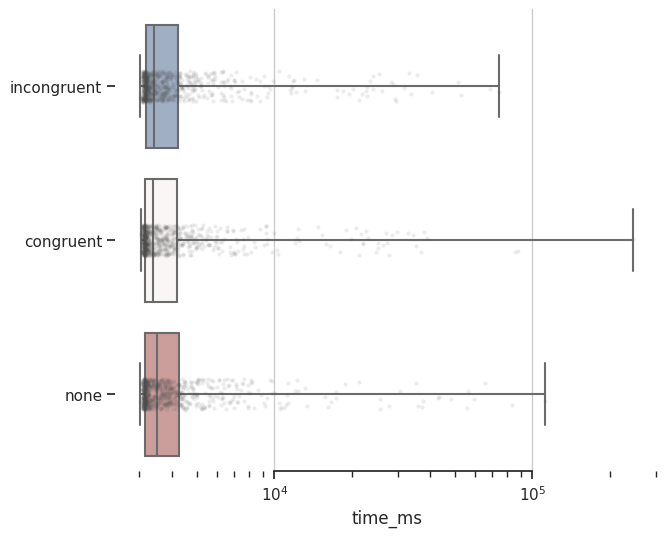

In [101]:
# Set the style of the graph
sns.set_theme(style='ticks')

# Initialize the figure with a logarithmic x-axis and specify the figure size
fig, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

# Plotting boxplot
sns.boxplot(
    data=work_df2, x='time_ms', y='feedbackType', 
    palette="vlag", whis=[0, 100],  showfliers=False
)

# Add points to show each observation
sns.stripplot(
    data=work_df, x='time_ms', y='feedbackType', size=3, color=".3",alpha=0.1, dodge=True
)


# Set the x-axis limits to 2500 and 10000 ms
#ax.set_xlim(2500, 10000)

# Show the plot
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
#plt.show()



First thing we can see is there is a huge spread in response time. And a hight Kurtosis 

At first sight there are no big differences overall in reponse time. When looking with attention Incongruent and Congruent are more similar. And "None" is slightly a more slower response time. 



Additionally we need to remove two participants participant 27 and the partipant over the limit of 30 years

In [102]:
work_df_no_outl = work_df2[~work_df2['ptcp'].isin(['tsvr27', 'tsvr26'])]

Next we are going to cut in 4226 ms as is the upper limit for Quartile 3 of RT

In [103]:
work_df_no_outl = work_df_no_outl[work_df_no_outl['time_ms'] <= 4226]

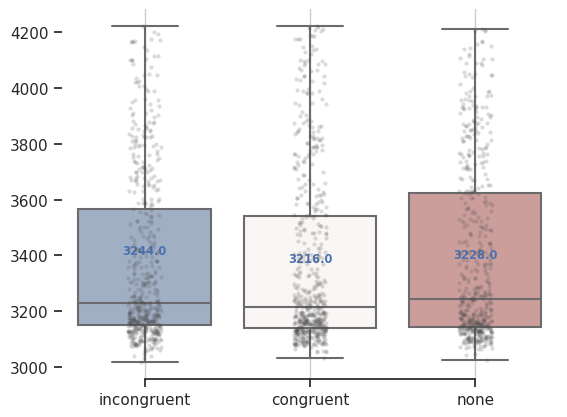

In [104]:


# Set the style of the graph
sns.set_theme(style='ticks')

# Initialize the figure with a logarithmic x-axis and specify the figure size
fig, ax = plt.subplots()
#ax.set_yscale("log")

# Plotting boxplot
box_plot = sns.boxplot(
    data=work_df_no_outl, y='time_ms', x='feedbackType', 
    palette="vlag", whis=[0, 100],  showfliers=False
)


medians = work_df_no_outl.groupby(['feedbackType'])['time_ms'].median()
medians = medians.reindex(index = ['none','congruent','incongruent'])
vertical_offset = work_df_no_outl['time_ms'].median() * 0.05 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='b',weight='semibold')




# Add points to show each observation
sns.stripplot(
    data=work_df_no_outl, y='time_ms', x='feedbackType', size=3, color=".3",alpha=0.2, dodge=True
)


# Set the x-axis limits to 2500 and 10000 ms
#ax.set_xlim(2500, 10000)

# Show the plot
ax.xaxis.grid(True)
ax.set(ylabel="")
ax.set(xlabel="")
sns.despine(trim=True, left=True)

Now we consider each trial individually and we can see de difference between conditions, somewhat more clearly. With median value difference of 10 ms between congruent and incongruent and a difference of 30ms and 20ms between None-congruent and none-incongruent.

If we consider the difference for each Participant:

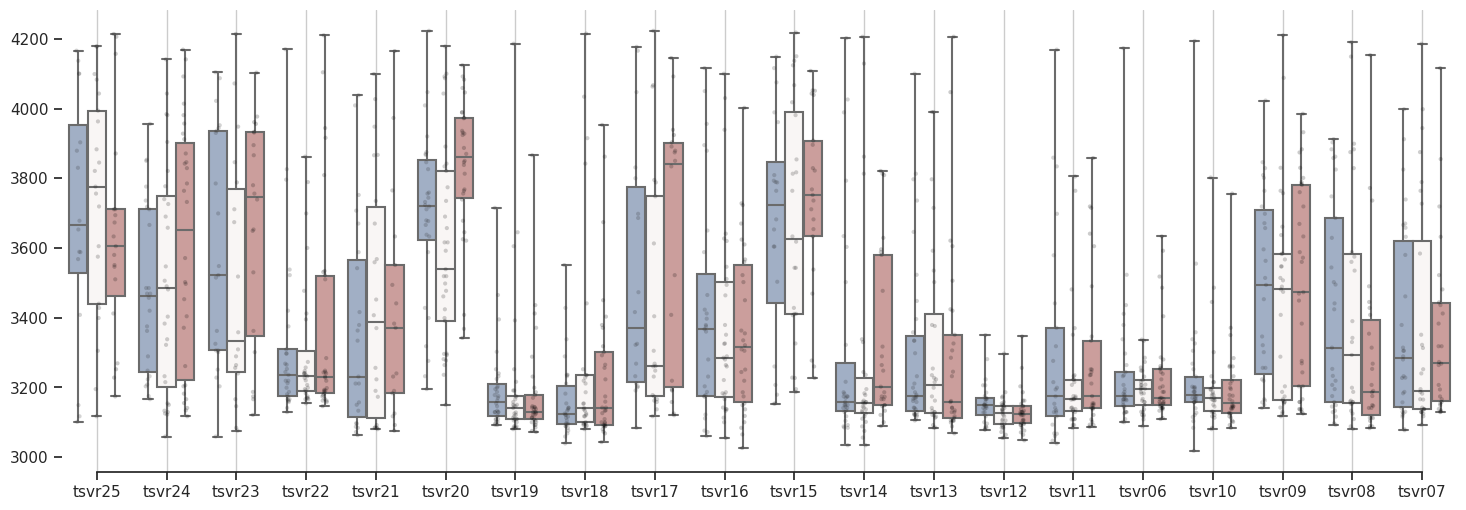

In [105]:

sns.set_theme(style='ticks')

# Initialize the figure with a logarithmic x-axis and specify the figure size
fig, ax = plt.subplots(figsize=(18,6))
#ax.set_yscale("log")

# Plotting boxplot
box_plot = sns.boxplot(
    data=work_df_no_outl, y='time_ms', x='ptcp', hue='feedbackType',
    palette="vlag", whis=[0, 100],  showfliers=False
)

'''
medians = work_df_no_outl.groupby(['feedbackType'])['time_ms'].median()
medians = medians.reindex(index = ['none','congruent','incongruent'])
vertical_offset = work_df_no_outl['time_ms'].median() * 0.05 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='b',weight='semibold')

'''


# Add points to show each observation
sns.stripplot(
    data=work_df_no_outl, y='time_ms', x='ptcp', hue='feedbackType', size=3, palette='dark:black',alpha=0.2, dodge=True
)


# Set the x-axis limits to 2500 and 10000 ms
#ax.set_xlim(2500, 10000)

ax.get_legend().remove()

# Show the plot
ax.xaxis.grid(True)
ax.set(ylabel="")
ax.set(xlabel="")
sns.despine(trim=True, left=True)

Here we see the RT (ms) for each participant devided by conditions. First thing that pops into the eye is how different is for each individual. There is no clear patern. Also participant 27 is incomplete and needs to be remove. As well as the participant with 50 years. 

In [106]:
# Calculate the median RT for each condition
median_rt = work_df_no_outl.groupby(['ptcp', 'feedbackType'])['time_ms'].median().unstack()

# Check for the pattern
pattern_count = 0
f_pattern_count = 0
s_pattern_count = 0 
t_pattern_count = 0 
fo_pattern_count = 0 
fi_pattern_count = 0 

for participant in median_rt.index:
    if (median_rt.loc[participant, 'congruent'] < median_rt.loc[participant, 'incongruent']
            < median_rt.loc[participant, 'none']):
        pattern_count += 1
    elif (median_rt.loc[participant, 'incongruent'] < median_rt.loc[participant, 'congruent']
            < median_rt.loc[participant, 'none']):
        f_pattern_count += 1
    elif (median_rt.loc[participant, 'none'] < median_rt.loc[participant, 'congruent']
            < median_rt.loc[participant, 'incongruent']):
        s_pattern_count += 1
    elif (median_rt.loc[participant, 'congruent'] < median_rt.loc[participant, 'none']
            < median_rt.loc[participant, 'incongruent']):
        t_pattern_count += 1
    elif (median_rt.loc[participant, 'incongruent'] < median_rt.loc[participant, 'none']
            < median_rt.loc[participant, 'congruent']):
        fo_pattern_count += 1
    elif (median_rt.loc[participant, 'none'] < median_rt.loc[participant, 'incongruent']
            < median_rt.loc[participant, 'congruent']):
        fi_pattern_count += 1

# Display the count of participants with the pattern
print(f"Participants with 'congruent median' < 'incongruent median' < 'none median': {pattern_count}")
print(f"Participants with 'incongruent median' < 'congruent median' < 'none median': {f_pattern_count}")
print(f"Participants with 'none median' < 'congruent median' < 'incongruent median': {s_pattern_count}")
print(f"Participants with 'congruent median' < 'none median' < 'incongruent median': {t_pattern_count}")
print(f"Participants with 'incongruent median' < 'none median' < 'congruent median': {fo_pattern_count}")
print(f"Participants with 'none median' < 'incongruent median' < 'congruent median': {fi_pattern_count}")

Participants with 'congruent median' < 'incongruent median' < 'none median': 6
Participants with 'incongruent median' < 'congruent median' < 'none median': 2
Participants with 'none median' < 'congruent median' < 'incongruent median': 6
Participants with 'congruent median' < 'none median' < 'incongruent median': 2
Participants with 'incongruent median' < 'none median' < 'congruent median': 1
Participants with 'none median' < 'incongruent median' < 'congruent median': 3


Having a closer look we see that for 11 participants (50%) the congruent conditions was the fastest reaction time. On this group is the mode of participants, in which 6 participants (27%) had the congruent condition as the fastes and the incongruent condition as the slowestm no Haptic feedback was in the middle as we guessed. 

A second group had the 'none' condition as the fastest 3 ptcp (13%) + 3 ptcp (13%) 

Incongruent condition was the fastest only for 5 participants (22%)

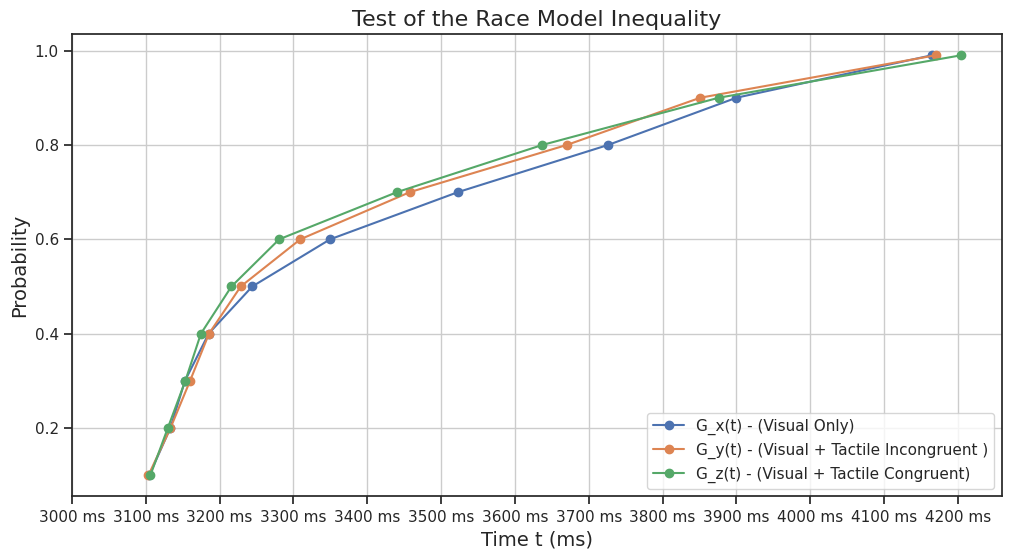

In [109]:
#---CUMULATIVE DISTRIBUTION---------------------------------------------
# using correct counter 
# Referencing code from Rolf Ulrich and Chatgpt adaptation. 
import numpy as np
import matplotlib.pyplot as plt

def race_model(X, Y, Z, P, Plot):
    # X, Y, Z are arrays with RTs for conditions Cx, Cy, Cz, respectively.
    # P is an array which contains the probabilities for computing percentiles.
    # If Plot is True, a plot of the result is generated.
    
    # Check for ties and get maximum t value
    Ux, Rx, Cx = ties(X)
    Uy, Ry, Cy = ties(Y)
    Uz, Rz, Cz = ties(Z)
    tmax = int(np.ceil(max(max(X), max(Y), max(Z))))
    T = np.arange(1, tmax + 1)
    
    # Get function values of G
    Gx = CDF(Ux, Rx, Cx, tmax) 
    Gy = CDF(Uy, Ry, Cy, tmax)
    Gz = CDF(Uz, Rz, Cz, tmax)
    
    # Compute B = Gx plus Gy
    B = [Gx[t] + Gy[t] for t in range(tmax)]
    
    # Check whether requested percentiles can be computed
    OKx = check(Ux[0], P[0], Gx)
    if not OKx:
        print('Not enough X values to compute requested percentiles')
        return [None, None, None, None]
    
    OKy = check(Uy[0], P[0], Gy)
    if not OKy:
        print('Not enough Y values to compute requested percentiles')
        return [None, None, None, None]
    
    OKz = check(Uz[0], P[0], Gz)
    if not OKz:
        print('Not enough Z values to compute requested percentiles')
        return [None, None, None, None]
    
    # Determine percentiles
    Xp = get_percentile(P, Gx, tmax)
    Yp = get_percentile(P, Gy, tmax)
    Zp = get_percentile(P, Gz, tmax)
    Bp = get_percentile(P, B, tmax)
    
    # Generate a plot if requested
    if Plot:
        plt.figure(figsize=(12,6))
        #bin_edges = range(3000, int(work_df_no_outl['time_ms'].max()) + 100, 100)
        plt.plot(Xp, P, '-o', label='G_x(t) - (Visual Only)')
        plt.plot(Yp, P, '-o', label='G_y(t) - (Visual + Tactile Incongruent )')
        plt.plot(Zp, P, '-o', label='G_z(t) - (Visual + Tactile Congruent)')
        
        #plt.plot(Bp, P, '-', label='G_x(t)+G_y(t)')
        #plt.axis([min(Ux + Uy + Uz) - 10, 
        #          tmax + 10, 
        #          -0.03, 1.03])
        # Define the time range and step for x-axis labels
        x_ticks = range(3000, tmax + 10, 100)

# Set the x-tick positions and labels
        plt.xticks(x_ticks, [str(tick) + ' ms' for tick in x_ticks])
        plt.grid()
        plt.title('Test of the Race Model Inequality', fontsize=16)
        plt.xlabel('Time t (ms)', fontsize=14)
        plt.ylabel('Probability', fontsize=14)
        plt.legend(loc=4)
        
        plt.show()
    
    return Xp, Yp, Zp, Bp

def check(U1, P1, G):
    for t in range(U1 - 2, U1 + 3):
        if G[t] > P1 and G[t - 1] == 0:
            return False
    return True

def get_percentile(P, G, tmax):
    Tp = []
    for p in P:
        cc = 100
        c = 0
        for t in range(tmax):
            if abs(G[t] - p) < cc:
                c = t
                cc = abs(G[t] - p)
        
        if p > G[c]:
            Tp.append(c + (p - G[c]) / (G[c + 1] - G[c]))
        else:
            Tp.append(c + (p - G[c]) / (G[c] - G[c - 1]))
    return Tp

def ties(W):
    # Count the number k of unique values and store these values in U.
    W = sorted(W)
    n = len(W)
    k = 1
    U = [W[0]]
    
    for i in range(1, n):
        if W[i] != W[i - 1]:
            k += 1
            U.append(W[i])
    
    # Determine the number of replications R
    R = [0] * k
    
    for i in range(k):
        for j in range(n):
            if U[i] == W[j]:
                R[i] += 1
    
    # Determine the cumulative frequency
    C = [0] * k
    C[0] = R[0]
    
    for i in range(1, k):
        C[i] = C[i - 1] + R[i]
    
    return U, R, C

def CDF(U, R, C, maximum):
    G = [0] * maximum
    k = len(U)
    n = C[k - 1]
    
    for i in range(k):
        U[i] = round(U[i])
    
    for t in range(U[0]):
        G[t] = 0
    
    for t in range(U[0], U[1]):
        G[t] = (R[0] / 2 + (R[0] + R[1]) / 2 * (t - U[0]) / (U[1] - U[0])) / n
    
    for i in range(1, k - 1):
        for t in range(U[i], U[i + 1]):
            G[t] = (C[i - 1] + R[i] / 2 + (R[i] + R[i + 1]) / 2 * (t - U[i]) / (U[i + 1] - U[i])) / n
    
    for t in range(U[k - 1], maximum):
        G[t] = 1
    
    return G
# Creating function data from my data 
X = work_df_no_outl.loc[work_df_no_outl['feedbackType'] == 'none', 'time_ms']
Y = work_df_no_outl.loc[work_df_no_outl['feedbackType'] == 'incongruent', 'time_ms']
Z = work_df_no_outl.loc[work_df_no_outl['feedbackType'] == 'congruent', 'time_ms']
#
#X = work_df2.loc[work_df2['feedbackType'] == 'none', 'time_ms']
#Y = work_df2.loc[work_df2['feedbackType'] == 'incongruent', 'time_ms']
#Z = work_df2.loc[work_df2['feedbackType'] == 'congruent', 'time_ms']

# Example usage:
#X = [10, 15, 20, 25] 
#Y = [12, 16, 18, 24]
#Z = [9, 14, 21, 27]
P = [ 0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]
Plot = True

Xp, Yp, Zp, Bp = race_model(X, Y, Z, P, Plot)

I as in our reference paper will take time bins. Wether to take the same time bins as in reference paper is not possible. Since the ask is a perception task, the time range runs between 0 and 1 seconds. In our VR-memory task individuals respond on a different time range. There for we consider from 3000 ms onward taking 20 bins of 100ms. untill

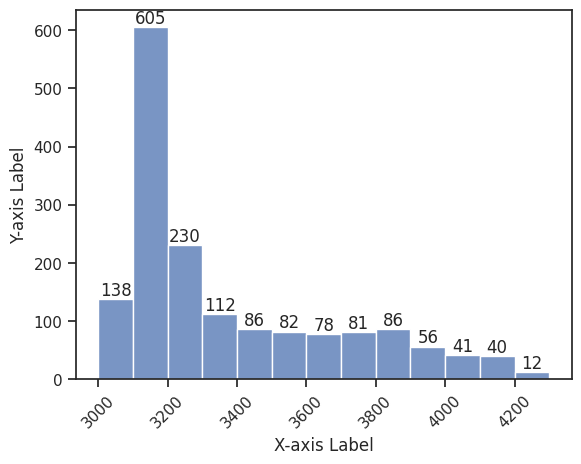

In [108]:

# Define the bin edges
bin_edges = range(3000, int(work_df_no_outl['time_ms'].max()) + 100, 100)

# Create the histogram with custom bin edges
sns.histplot(data=work_df_no_outl, x='time_ms', bins=bin_edges, stat='count')

# Customize the number of x-tick labels
plt.xticks(rotation=45)

# Get the current axis
ax = plt.gca()

# Annotate each bar with its count
for bar in ax.patches:
    ax.annotate(f'{int(bar.get_height())}', 
                (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                ha='center', va='bottom')

# Add labels to the x and y axes
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')

# Show the plot
plt.show()
